<!-- conda install -c menpo opencv -->
<!-- conda install -c conda-forge traceback2 -->
<!-- conda install -c conda-forge dlib -->

In [17]:
# %pip install opencv-python
# %pip install traceback2
# %pip install Cmake
# %pip install dlib
# %pip install easyocr


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from traceback2 import print_tb
import dlib

In [14]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_homography_points(M, points):
    new_bb = np.zeros_like(points)

    for i,coord in enumerate(points):

        v = [coord[0],coord[1],1]
        calculated = np.dot(M,v)
        calculated_scaled = calculated/calculated[2]
        new_bb[i] = (calculated_scaled[0], calculated_scaled[1])

    return new_bb


def get_warpPerspective(image_orig, M2, dst):

    img_homog = cv2.warpPerspective(image_orig, M2, (image_orig.shape[1], image_orig.shape[0]))
    dst_h = dst.reshape(4,2)
    new_bb =  get_homography_points(M2, dst_h)
    warp_image = warpImg(img_homog, new_bb , image_orig.shape[0], image_orig.shape[1])

    return warp_image

def get_angle_and_box_coord(dst):
    
    # cv.minAreaRect returns:
    # (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(c)
    rect = cv2.minAreaRect(dst)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Retrieve the key parameters of the rotated bounding box
    box_center = (int(rect[0][0]),int(rect[0][1])) 
    box_width = int(rect[1][0])
    box_height = int(rect[1][1])
    angle = int(rect[2])

    if box_width < box_height:
        angle = 90 - angle
    else:
        angle = -angle      
    print("Rotation Angle: " + str(angle) + " degrees")

    return -angle, box

def rotate_bbox(bb, cx, cy, h, w, theta):
    new_bb = np.zeros_like(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def reorder(myPoints):

    myPointsNew = np.zeros_like(myPoints)
    myPoints = myPoints.reshape((4,2))
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]

    diff = np.diff(myPoints, axis = 1)
    
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]

    return myPointsNew


def warpImg(img, points, w, h):

    points = reorder(points)
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0], [w,0], [0,h], [w,h]])
    matrix =  cv2.getPerspectiveTransform(pts1, pts2)
    imgWarp = cv2.warpPerspective(img, matrix, (w,h))

    return imgWarp

def findFaces(image):
    faces = detector(image)
    num_of_faces = len(faces)
    print("Number of Faces:", num_of_faces )
    if (not num_of_faces):
        return None

    for face in faces:
        x1 = face.left()   - 30
        y1 = face.top()    - 70
        x2 = face.right()  + 10
        y2 = face.bottom() + 30
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255 , 0), 3)
        face_crop = image[y1:y2, x1:x2]
        cropFaceRegions(image, x1, y1, x2, y2)
        return face_crop
        

def cropFaceRegions(image,x1, y1, x2, y2):

    face_crop = image[y1:y2, x1:x2]
    #cv2.imshow("crop region:", face_crop)
    plt.imsave("croppedFaces/crop_face.png", face_crop)
    #cv2.waitKey(0)
    return face_crop

def is_two_image_same(img1, img2, face_match_count):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    print("Total good matches:", len(good))       
    good = good[:face_match_count]

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good, None,flags=2)
    plt.title("Face Match")
    plt.imshow(img3, 'gray'),plt.show()
    print("Matches are found - %d/%d" % (len(good), face_match_count))

    if len(good) >= face_match_count:
        print("Faces are similar")
        return True
    else :
        print("Faces are not similar")
    return False

def applyBlur(image):
    return cv2.blur(image,(3,3))

def resizeImage(image):
    h, w = image.shape[0:2]
    return cv2.resize(image, (w+100, h+100), cv2.INTER_LINEAR)

libpng warning: iCCP: known incorrect sRGB profile


Total good matches: 138
Rotation Angle: -42 degrees
Number of Faces: 1
Number of Faces: 1


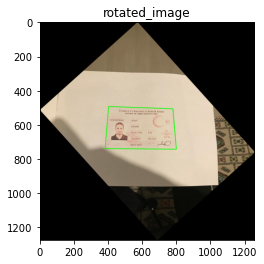

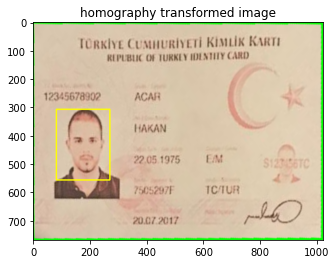

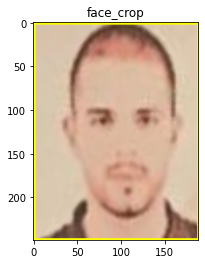

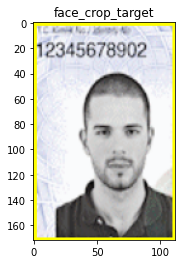

Total good matches: 25


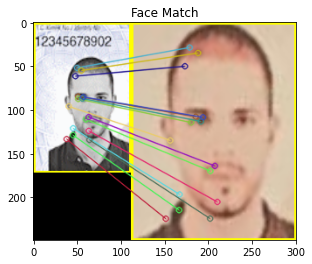

Matches are found - 15/15
Faces are similar


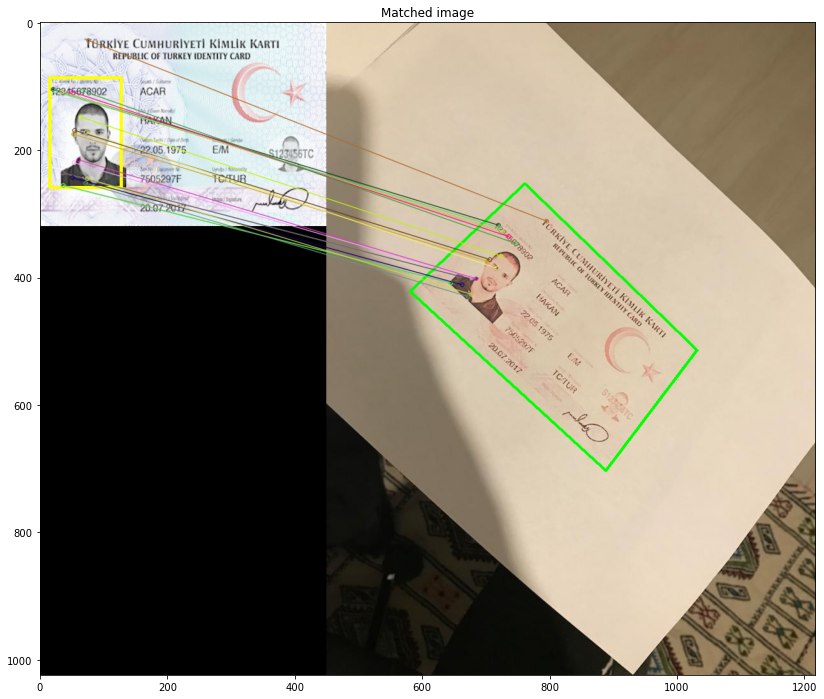

In [16]:
def siftMatching(img1, img2):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    print("Total good matches:", len(good))       
    good = good[:20]
    return kp1, kp2, good


template = cv2.imread("test/testcard.png")
sample = cv2.imread("train/tc_ID_rot.jpg")

def main():
    MIN_MATCH_COUNT = 20

    img1 = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)         # trainImage
    img2 = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)           # queryImage
    img1 = resizeImage(img1)

    kp1, kp2, good = siftMatching(img1, img2)

    if len(good) >= MIN_MATCH_COUNT:

        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        M2, mask2 = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
        h,w,_ = img1.shape
    
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        border = cv2.polylines(img2, [np.int32(dst)], True, (0, 255, 0), 3)

        warped_image = get_warpPerspective(img2, M2, dst)
       
        (heigth_q, width_q) = img2.shape[:2]
        (cx, cy) = (width_q // 2, heigth_q // 2)

        angle, box = get_angle_and_box_coord(dst)
        
        rotated_img = rotate_bound(img2, angle)
        
        new_bbox = rotate_bbox(box, cx, cy, heigth_q, width_q, angle)
       
        warp_image = warpImg(rotated_img, new_bbox ,  heigth_q, width_q)
        
        face_crop_img_query = findFaces(warped_image)
        face_crop_img_target = findFaces(img1)
        
        if(img1 is not None):
            plt.title("rotated_image")
            plt.imshow(rotated_img)
            plt.show()
        
        if(warped_image  is not None):
            plt.title("homography transformed image")
            plt.imshow(warped_image)
            plt.show()
        
        if(face_crop_img_query is not None):
            plt.title("face_crop")
            plt.imshow(face_crop_img_query)
            plt.show()
        
        if(face_crop_img_target is not None and face_crop_img_query is not None):
            plt.title("face_crop_target")
            plt.imshow(face_crop_img_target)
            plt.show()
            is_two_image_same(face_crop_img_target, face_crop_img_query, 15)
        

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good, None,flags=2)

    fig = plt.figure(figsize=(16, 12))
    plt.title("Matched image")
    plt.imshow(img3, 'gray'),plt.show()

  

if __name__ == '__main__':
    main()

In [5]:
import easyocr
reader = easyocr.Reader(['es','en'])
result = reader.readtext(template, detail=0)
print(result)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


['SENAC', 'Del Istmo', 'Se', 'CYT', 'SENAC', '0', 'cous']
